In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/transformed/final_dataframe.csv', index_col=0)

In [3]:
class GameCell(tf.keras.layers.Layer):

    def __init__(self, states, teams, lines_len, scores_len):
        super(GameCell, self).__init__()
        self.states = states
        self.teams = teams
        self.lines_len = lines_len
        self.scores_len = scores_len
        self.state_size = tf.TensorShape([teams, states])

    def build(self, input_shape ):
        self.Bz = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Br = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Bm = self.add_weight(
            shape=[self.states*2, 4 + self.lines_len + self.scores_len])
        self.Az = self.add_weight(
            shape=[self.states*2, self.states*2], 
            initializer=tf.keras.initializers.Identity(gain=0.5))
        self.Ar = self.add_weight(
            shape=[self.states*2, self.states*2],)
            # initializer=tf.keras.initializers.Identity(gain=0.25))
        self.Am = self.add_weight(
            shape=[self.states*2, self.states*2],)
            # initializer=tf.keras.initializers.Identity(gain=0.25))
        self.dz = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Zeros)
        self.dr = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Ones())
        self.dm = self.add_weight(
            shape=[self.states*2, 1],)
            # initializer=tf.keras.initializers.Zeros)
        super(GameCell, self).build(input_shape)
    
    def call(self, inputs, state):
        teams, u = inputs
        u = tf.reshape(u, (-1, 1))
        state = state[0]
        x_k = self._get_state(state, teams)
        x_kp = self._gru(u, x_k)
        state = self._update_state(state, teams, x_kp, x_k)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def _gru(self, u, x):
        z = self.Az @ x + self.Bz @ u + self.dz
        z = tf.math.sigmoid(z)
        r = self.Ar @ x + self.Br @ u - self.dr
        r = tf.math.sigmoid(r)
        m = self.Am @ (r * x) + self.Bm @ u + self.dm
        m = tf.math.tanh(m)
        return z * x + (1-z) * m

    @staticmethod
    def _get_state(state, teams):
        states = tf.gather_nd(state[0], teams)
        return tf.reshape(states, (-1, 1))
    
    @staticmethod
    def _update_state(state, teams, x_kp, x_k):
        dx = x_kp - x_k
        dx = tf.reshape(dx, (2, -1))
        indices = tf.reshape(teams, (2, 1))
        return state[0] + tf.scatter_nd(indices, dx, state[0].shape)

class GameRNN(tf.keras.layers.RNN):
    
    def __init__(self, states, teams, lines_len, scores_len, 
                 return_sequences=True, return_state=False,
                 stateful=True, unroll=False):
        cell = GameCell(states, teams, lines_len, scores_len)
        super(GameRNN, self).__init__(cell, 
            return_sequences=return_sequences, return_state=return_state,
            stateful=stateful, unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(GameRNN, self).call(
            inputs, initial_state=initial_state, constants=constants)

In [4]:
class PredictionLayer(tf.keras.layers.Layer):

    def __init__(self, states, predictions=2):
        super(PredictionLayer, self).__init__()
        self.states = states
        self.predictions = predictions

    def build(self, input_shape):
        self.C = self.add_weight(
            shape=[self.predictions, self.states*2])
        self.D = self.add_weight(
            shape=[self.predictions, 6])
        self.const = self.add_weight(
            shape=[self.predictions, 1])
        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs):
        u_kp, state, teams = inputs
        u_kp = tf.expand_dims(u_kp, axis=-1)[0]
        x_kp = self._get_state(state, teams)
        Cx = tf.transpose(tf.tensordot(self.C, x_kp, axes=[[1], [1]]), perm=[1, 0, 2])
        Du = tf.transpose(tf.tensordot(self.D, u_kp, axes=[[1], [1]]), perm=[1, 0, 2])
        return tf.expand_dims(Cx + Du + self.const, axis=0)

    @staticmethod
    def _get_state(state, teams):
        seq_len = teams.shape[1]
        seq_len_range = tf.expand_dims(
            tf.range(seq_len, dtype=tf.int32), axis=1)
        home_indices = tf.concat((seq_len_range, teams[0, :, 0]), axis=1)
        visitor_indices = tf.concat((seq_len_range, teams[0, :, 1]), axis=1)
        state_home = tf.gather_nd(state[0], home_indices)
        state_visitor = tf.gather_nd(state[0], visitor_indices)
        state_teams = tf.concat((state_home, state_visitor), axis=1)
        return tf.expand_dims(state_teams, axis=-1)

In [5]:
def build_model(seq_len, states, teams, lines_len=4, scores_len=8):
    
    teams_k = tf.keras.layers.Input(batch_shape=(1, seq_len, 2, 1), dtype=tf.int32)
    days_off_k = tf.keras.layers.Input(batch_shape=(1, seq_len, 4))
    lines_k = tf.keras.layers.Input(batch_shape=(1, seq_len, lines_len))
    scores_k = tf.keras.layers.Input(batch_shape=(1, seq_len, scores_len))

    u_k = tf.keras.layers.concatenate([days_off_k, lines_k, scores_k])

    x_kp = GameRNN(states, teams, lines_len, scores_len)(tuple([teams_k, u_k]))

    teams_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 2, 1), dtype=tf.int32)
    days_off_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 4))
    lines_kp = tf.keras.layers.Input(batch_shape=(1, seq_len, 2))

    u_kp = tf.keras.layers.concatenate([days_off_kp, lines_kp])

    preds = PredictionLayer(states)([u_kp, x_kp, teams_kp])
    preds = tf.keras.layers.Reshape((seq_len, -1))(preds)
    preds = tf.keras.layers.Activation('sigmoid')(preds)

    score_preds = PredictionLayer(states)([u_kp, x_kp, teams_kp])
    score_preds = tf.keras.layers.Reshape((seq_len, -1))(score_preds)

    return tf.keras.Model(
        inputs=[teams_k, days_off_k, lines_k, scores_k, teams_kp, days_off_kp, lines_kp],
        outputs=[preds, score_preds])

In [6]:
df[['home_team', 'visitor_team']] = df[['home_team', 'visitor_team']].astype('category')
df['home_team_cat'] = df['home_team'].cat.codes
df['visitor_team_cat'] = df['visitor_team'].cat.codes
df['home_final'] = df[[col for col in df.columns if 'H ' in col]].sum(axis=1)
df['visitor_final'] = df[[col for col in df.columns if 'V ' in col]].sum(axis=1)
scaled_scores = StandardScaler().fit_transform(df[['home_final', 'visitor_final']])
df['home_final_scaled'] = scaled_scores[:, 0]
df['visitor_final_scaled'] = scaled_scores[:, 1]

In [7]:
seq_len = 100
state_size = 6
teams = len(df['visitor_team'].cat.categories)
line_used = 'open'

In [8]:
def map_to_cat(x, categories):
    if x == categories[0]:
        return 1
    elif x == categories[1]:
        return 0
    else:
        return 0.5

In [9]:
df['open_spread_win_cat'] = df['open_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['close_spread_win_cat'] = df['close_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['open_total_win_cat'] = df['open_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))
df['close_total_win_cat'] = df['close_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))

In [10]:
train = range(27, 6827)
test = range(6827, len(df)-1)

seq_start = [train[0] + len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series_train = [range(start, start+seq_len) for start in seq_start]
time_series_plus_train = [range(start+1, start+1+seq_len) for start in seq_start]
seq_start_test = [test[0] + seq_len*i for i in range(len(test)//seq_len)]
time_series_test = [range(start, start+seq_len) for start in seq_start_test]
time_series_plus_test = [range(start+1, start+1+seq_len) for start in seq_start_test]

In [11]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [12]:
cols = ['home_team_cat', 'visitor_team_cat']
teams_train = convert_to_time_series(
    df[cols].values, time_series_train).astype(np.int32)
teams_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train).astype(np.int32)
teams_test = convert_to_time_series(
    df[cols].values, time_series_test).astype(np.int32)
teams_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test).astype(np.int32)

In [13]:
cols = ['home_days_since_home', 'home_days_since_away', 'visitor_days_since_home', 'visitor_days_since_away']
days_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = days_scaled[:, i]

days_off_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
days_off_plus_train = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_train)
days_off_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)
days_off_plus_test = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_test)

In [14]:
cols = ['home_score_open', 'visitor_score_open', 'home_score_close', 'visitor_score_close']
lines_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = lines_scaled[:, i]

lines_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
lines_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = [col for col in scaled_cols if line_used in col]
lines_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
lines_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

In [15]:
cols = ['H 1st', 'H 2nd', 'H 3rd', 'H 4th', 'V 1st', 'V 2nd', 'V 3rd', 'V 4th']
scores_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = scores_scaled[:, i]

scores_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
scores_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = ['home_final_scaled', 'visitor_final_scaled']
scores_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
scores_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

cols = ['open_spread_win_cat', 'open_total_win_cat', 'close_spread_win_cat', 'close_total_win_cat']
cols = [col for col in cols if line_used in col]
outcomes_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train) / 2 + 0.25
outcomes_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test) / 2 + 0.25

In [16]:
model = build_model(seq_len, state_size, teams)

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, 100, 8)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(1, 100, 4)]        0                                            
_______________________________________________________________________________________

In [18]:
import copy

def shuffle_games(X, distance=2, fraction=0.25):
    reorder = np.random.choice(X[0].shape[1] - distance, 
                               size=(int(X[0].shape[1] * fraction)),
                               replace=False)
    targets = reorder + distance
    keep = np.array([k for k, r in enumerate(reorder) if r not in targets])
    reorder = reorder[keep]
    targets = targets[keep]

    X_out = []
    for tensor in X:
        tensor[:, np.append(targets, reorder)] = tensor[:, np.append(reorder, targets)]
        X_out += [tensor]
    
    return X_out

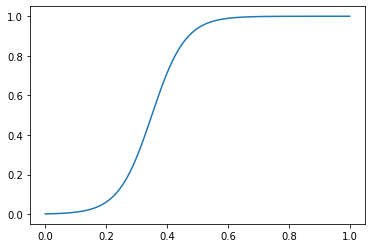

In [19]:
def sigmoid(x):
    return 1/(1+np.exp(-(x-0.35)/0.055))

x = np.linspace(0, 1, len(train))
sample_weights = np.expand_dims(sigmoid(x),axis=1)

sample_weights_final = [sample_weights.reshape(68, 100), sample_weights.reshape(68, 100)]

plt.plot(x, sample_weights)
plt.show()

In [25]:
opt = tf.keras.optimizers.Adam(lr=0.002)
model.compile(
    optimizer=opt, loss=['binary_crossentropy', 'mean_squared_error'], metrics=['accuracy']
)
epochs = 10

In [26]:
X = [np.expand_dims(teams_train, axis=-1), days_off_train, lines_train, scores_train, 
     np.expand_dims(teams_plus_train, axis=-1), days_off_plus_train, lines_plus_train,
     outcomes_plus_train, scores_plus_train]

for i in range(epochs):
    print('Epoch {}'.format(str(i+1)))
    model.reset_states()
    #X = shuffle_games(copy.deepcopy(X))
    model.fit(
        x=X[:7],
        y=X[7:],
        batch_size=1,
        epochs=1,
        sample_weight=sample_weights_final,
        verbose=1
    )

Epoch 1
68/68 [==============================] - 2s 23ms/step - loss: 0.8955 - activation_loss: 0.4481 - reshape_1_loss: 0.4475 - activation_accuracy: 0.4966 - reshape_1_accuracy: 0.6554
Epoch 2
68/68 [==============================] - 1s 22ms/step - loss: 0.8916 - activation_loss: 0.4472 - reshape_1_loss: 0.4443 - activation_accuracy: 0.5441 - reshape_1_accuracy: 0.6574
Epoch 3
68/68 [==============================] - 1s 21ms/step - loss: 0.8931 - activation_loss: 0.4473 - reshape_1_loss: 0.4459 - activation_accuracy: 0.5332 - reshape_1_accuracy: 0.6610
Epoch 4
68/68 [==============================] - 2s 22ms/step - loss: 0.8901 - activation_loss: 0.4471 - reshape_1_loss: 0.4430 - activation_accuracy: 0.5385 - reshape_1_accuracy: 0.6560
Epoch 5
68/68 [==============================] - 1s 22ms/step - loss: 0.8863 - activation_loss: 0.4469 - reshape_1_loss: 0.4394 - activation_accuracy: 0.5424 - reshape_1_accuracy: 0.6588
Epoch 6
68/68 [==============================] - 1s 22ms/step - l

In [27]:
rnn_layer = model.layers[8]

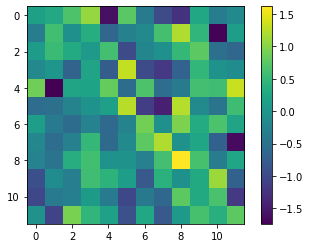

In [28]:
plt.imshow(rnn_layer.get_weights()[3])
plt.colorbar()

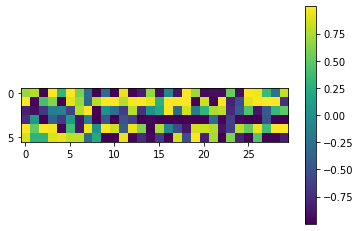

In [29]:
plt.imshow(rnn_layer.states[0][0].numpy().T)
plt.colorbar()

In [30]:
df_states = pd.DataFrame(rnn_layer.states[0][0].numpy().T, columns=list(df['home_team'].cat.categories))

<AxesSubplot:>

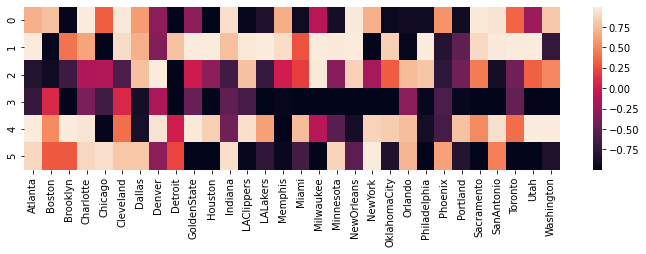

In [31]:
plt.rcParams['figure.figsize'] = 12, 3
sn.heatmap(df_states)

In [32]:
import copy
states = copy.deepcopy(rnn_layer.states)

In [33]:
rnn_layer.reset_states(states[0].numpy())

In [34]:
preds = []
score_preds = []
for batch in range(teams_test.shape[0]):
    line_preds, score_preds_ = model.predict(
        [np.expand_dims(teams_test, axis=-1)[batch: batch+1], 
            days_off_test[batch: batch+1], 
            lines_test[batch: batch+1], scores_test[batch: batch+1], 
            np.expand_dims(teams_plus_test, axis=-1)[batch: batch+1], 
            days_off_plus_test[batch: batch+1], lines_plus_test[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0,10])
    preds += [line_preds]
    score_preds += [score_preds_]

[ 0.9664757  -0.9371995   0.52610254  0.08109027  0.7937541  -0.999832  ]
[-0.83347166  0.99907583 -0.7844914  -0.9950757   0.9988369  -0.96899205]
[ 0.41237146  0.9997788  -0.7792839  -0.9998138  -0.30643684 -0.9997562 ]
[-0.1339969   0.97737116 -0.8320728  -0.9930485   0.9308861   0.7983049 ]
[-0.8653503   0.9953187  -0.89737225 -0.9368014   0.9008365  -0.98229456]


In [35]:
score_preds = np.squeeze(np.stack(score_preds)).reshape(-1, 2)
preds = np.squeeze(np.stack(preds)).reshape(-1, 2)

In [36]:
rnn_layer.reset_states(np.zeros(states[0].numpy().shape))
preds_train = []
score_preds_train = []
for batch in range(teams_train.shape[0]):
    line_preds, score_preds_ = model.predict(
        [np.expand_dims(teams_train, axis=-1)[batch: batch+1], 
            days_off_train[batch: batch+1], 
            lines_train[batch: batch+1], scores_train[batch: batch+1], 
            np.expand_dims(teams_plus_train, axis=-1)[batch: batch+1], 
            days_off_plus_train[batch: batch+1], lines_plus_train[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0,10])
    preds_train += [line_preds]
    score_preds_train += [score_preds_]

[-0.28348255  0.8424524  -0.14482176 -0.47563767  0.9754859  -0.77966374]
[ 0.20755708 -0.8281113  -0.20743817 -0.7353262   0.8981155  -0.4992324 ]
[ 0.67582774 -0.05842519 -0.00713408 -0.98858994 -0.12481666  0.75308913]
[-0.7890218   0.1647501  -0.33583897 -0.50460064  0.68595916  0.38981077]
[ 0.9434434   0.48443532  0.17635196 -0.9638427   0.750232   -0.59740835]
[-0.9132279   0.63044816 -0.9505997  -0.99591696  0.6802207   0.47443476]
[-0.5054501   0.6845294   0.9268401  -0.99503994 -0.41403472  0.5854099 ]
[-0.9974595   0.6527786   0.8672036  -0.94658566  0.03999668 -0.9992705 ]
[-0.9336803  -0.17302978 -0.99559385 -0.9949144   0.09995878 -0.17045143]
[-0.17140996  0.7048118   0.17207038 -0.99879366  0.74885285 -0.5579543 ]
[ 0.5436896  -0.99335635  0.8150423  -0.9649401   0.7190448  -0.34909254]
[-0.21838331 -0.81050956  0.05712739  0.9009043   0.7209677   0.45788303]
[ 0.77630407 -0.9931655  -0.5074449  -0.9080292  -0.9312977  -0.11365153]
[ 0.15612793  0.39271498 -0.30154002 -

In [37]:
score_preds_train = np.squeeze(np.stack(score_preds_train)).reshape(-1, 2)
preds_train = np.squeeze(np.stack(preds_train)).reshape(-1, 2)

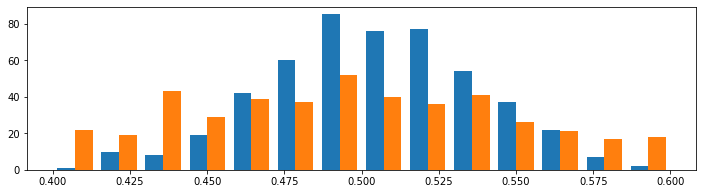

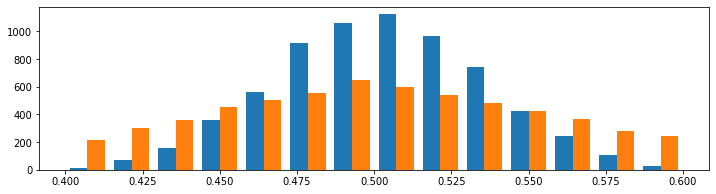

In [38]:
bins = np.linspace(0.4, 0.6, 15)
plt.hist(preds, bins=bins)
plt.show()

plt.hist(preds_train, bins=bins)
plt.show()

In [39]:
mean_ = df[['home_final', 'visitor_final']].mean(axis=0).values
std_ = df[['home_final', 'visitor_final']].std(axis=0).values

In [40]:
score_preds = score_preds * std_ + mean_
score_preds_train = score_preds_train * std_ + mean_

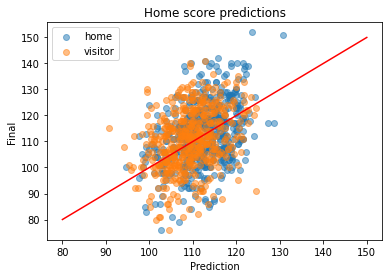

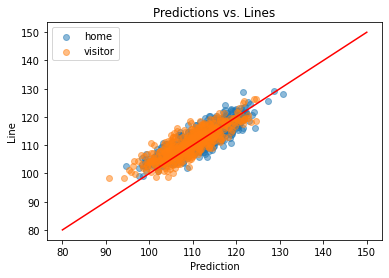

In [41]:
plt.rcParams['figure.figsize'] = 6, 4

plt.scatter(score_preds[:, 0], df['home_final'][-500:], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_final'][-500:], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions')
plt.show()

plt.scatter(score_preds[:, 0], df['home_score_open'][-500:], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_score_open'][-500:], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Line')
plt.title('Predictions vs. Lines')
plt.show()


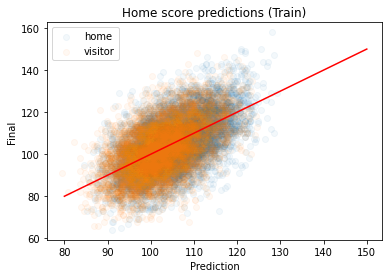

In [42]:
plt.scatter(score_preds_train[:, 0], df['home_final'][28:-500], alpha=0.05, label='home')
plt.scatter(score_preds_train[:, 1], df['visitor_final'][28:-500], alpha=0.05, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions (Train)')
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error

In [44]:
home_error = mean_absolute_error(df['home_final'][-500:], score_preds[:, 0])
visitor_error = mean_absolute_error(df['visitor_final'][-500:], score_preds[:, 1])
home_line_error = mean_absolute_error(df['home_final'][-500:], df['home_score_open'][-500:])
visitor_line_error = mean_absolute_error(df['visitor_final'][-500:], df['visitor_score_open'][-500:])
print(home_error)
print(visitor_error)
print(home_line_error)
print(visitor_line_error)

9.06545357843247
8.821344532271855
8.7715
8.5875


In [45]:
home_error_train = mean_absolute_error(df['home_final'][28:-500], score_preds_train[:, 0])
visitor_error_train = mean_absolute_error(df['visitor_final'][28:-500], score_preds_train[:, 1])
home_line_error_train = mean_absolute_error(df['home_final'][28:-500], df['home_score_open'][28:-500])
visitor_line_error_train = mean_absolute_error(df['visitor_final'][28:-500:], df['visitor_score_open'][28:-500])
print(home_error_train)
print(visitor_error_train)
print(home_line_error_train)
print(visitor_line_error_train)

8.062844525779857
8.158426879830525
8.300182977941176
8.333125845588235


In [46]:
df['final_spread'] = df['home_final'] - df['visitor_final']
df['final_total'] = df['home_final'] + df['visitor_final']

In [47]:
df['final_margin_from_open_spread'] = df['final_spread'] - (df['home_score_open'] - df['visitor_score_open'])
df['final_margin_from_open_total'] = df['final_total'] - (df['home_score_open'] + df['visitor_score_open'])

In [48]:
np.corrcoef(preds[:, 0], df['final_margin_from_open_spread'][-500:])

array([[1.        , 0.07210698],
       [0.07210698, 1.        ]])

In [49]:
np.corrcoef(preds[:, 0], np.sign(df['final_margin_from_open_spread'][-500:]))

array([[1.        , 0.00103814],
       [0.00103814, 1.        ]])

In [50]:
np.corrcoef(preds[:, 1], df['final_margin_from_open_total'][-500:])

array([[1.        , 0.07442009],
       [0.07442009, 1.        ]])

In [51]:
np.corrcoef(preds[:, 1], np.sign(df['final_margin_from_open_total'][-500:]))

array([[1.        , 0.06238725],
       [0.06238725, 1.        ]])

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
spread_model = LinearRegression()
total_model = LinearRegression()
spread_model.fit(preds[:, :1], df['final_margin_from_open_spread'][-500:])
total_model.fit(preds[:, 1:], df['final_margin_from_open_total'][-500:])

LinearRegression()

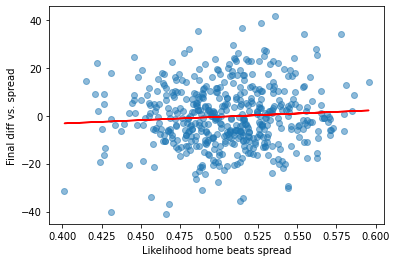

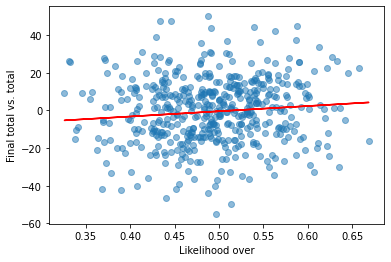

In [54]:
plt.scatter(preds[:, 0], df['final_margin_from_open_spread'][-500:], alpha=0.5)
plt.plot(preds[:, 0], spread_model.predict(preds[:, :1]), c='red')
plt.xlabel('Likelihood home beats spread')
plt.ylabel('Final diff vs. spread')
plt.show()

plt.scatter(preds[:, 1], df['final_margin_from_open_total'][-500:], alpha=0.5)
plt.plot(preds[:, 1], spread_model.predict(preds[:, 1:]), c='red')
plt.xlabel('Likelihood over')
plt.ylabel('Final total vs. total')
plt.show()

In [55]:
spread_wins = len(np.where((preds[:, 0] > 0.5) & (df['final_margin_from_open_spread'][-500:] > 0))[0])
spread_wins += len(np.where((preds[:, 0] < 0.5) & (df['final_margin_from_open_spread'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_spread'][-500:] == 0)[0])
win_fraction = spread_wins / den
win_fraction

0.4949290060851927

In [56]:
total_wins = len(np.where((preds[:, 1] > 0.5) & (df['final_margin_from_open_total'][-500:] > 0))[0])
total_wins += len(np.where((preds[:, 1] < 0.5) & (df['final_margin_from_open_total'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_total'][-500:] == 0)[0])
win_fraction = total_wins / den
win_fraction

0.5321285140562249

In [57]:
spread_wins_train = len(np.where((preds_train[:, 0] > 0.5) & (df['final_margin_from_open_spread'][28:-500] > 0))[0])
spread_wins_train += len(np.where((preds_train[:, 0] < 0.5) & (df['final_margin_from_open_spread'][28:-500] < 0))[0])
den = 6800 - len(np.where(df['final_margin_from_open_spread'][28:-500] == 0)[0])
win_fraction = spread_wins_train / den
win_fraction

0.5345138055222088

In [58]:
total_wins_train = len(np.where((preds_train[:, 1] > 0.5) & (df['final_margin_from_open_total'][28:-500] > 0))[0])
total_wins_train += len(np.where((preds_train[:, 1] < 0.5) & (df['final_margin_from_open_total'][28:-500] < 0))[0])
den = 6800 - len(np.where(df['final_margin_from_open_spread'][28:-500] == 0)[0])
win_fraction = total_wins_train / den
win_fraction

0.5919867947178872

In [63]:
import joblib
joblib.dump(model.get_weights(), '../models/prediction_model_v0.joblib')

['../models/prediction_model_v0.joblib']